# QIBA v2

In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
import original.T1_mapping.MJT_EdinburghUK.t1 as edinburgh
import original.T1_mapping.ST_SydneyAus.VFAT1mapping as sydney
import original.T1_mapping.McGill.vfa as mcgill
import matplotlib.pyplot as plt
import os
import urllib.request
import mat73
import numpy as np
from numpy.linalg import norm

plt.style.use('https://gist.github.com/notZaki/8bfb049230e307f4432fd68d24c603a1/raw/c0baa2a1c55afdf1764b26ee2ebeb1cbf26d8d98/pltstyle')

In [3]:
# Get the file
datafolder = "./data"
if not os.path.isdir(datafolder): os.makedirs(datafolder)

t1file = os.path.join(datafolder, "t1data_v2.mat")
if not os.path.isfile(t1file):
    urllib.request.urlretrieve("https://osf.io/3hwtc/download", t1file)

# Open file

t1data = mat73.loadmat(t1file)
t1data.keys()

dict_keys(['M0', 'T1', 'TR', 'fa', 'signal'])

In [4]:
def show_fits(fittedM0, fittedT1, truthdata = t1data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.imshow(fittedM0)
    ax1.grid(False)
    plt.sca(ax1)
    plt.title("M0")
    plt.xticks(np.arange(5, 150, 10), np.round((np.unique(truthdata.T1))).astype(int), rotation=45, ha="right")
    plt.yticks(np.arange(5, 70, 10), np.round((np.unique(truthdata.M0))).astype(int))
    
    ax2.imshow(fittedT1)
    ax2.grid(False)
    plt.sca(ax2)
    plt.title("T1")
    plt.xticks(np.arange(5, 150, 10), np.round((np.unique(truthdata.T1))).astype(int), rotation=45, ha="right")
    plt.yticks(np.arange(5, 70, 10), np.round((np.unique(truthdata.M0))).astype(int))
    
    fig.tight_layout()
    return

def show_err(fittedM0, fittedT1, truthdata = t1data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.imshow(percenterror(fittedM0, truthdata.M0), cmap = "PuOr_r", clim = (-100, 100))
    ax1.grid(False)
    plt.sca(ax1)
    plt.title("M0")
    plt.xticks(np.arange(5, 150, 10), np.round((np.unique(truthdata.T1))).astype(int), rotation=45, ha="right")
    plt.yticks(np.arange(5, 70, 10), np.round((np.unique(truthdata.M0))).astype(int))
    
    ax2.imshow(percenterror(fittedT1, truthdata.T1), cmap = "PuOr_r", clim = (-100, 100))
    ax2.grid(False)
    plt.sca(ax2)
    plt.title("T1")
    plt.xticks(np.arange(5, 150, 10), np.round((np.unique(truthdata.T1))).astype(int), rotation=45, ha="right")
    plt.yticks(np.arange(5, 70, 10), np.round((np.unique(truthdata.M0))).astype(int))
    
    fig.tight_layout()
    return


def percenterror(estimated, truth):
    return 100 * (estimated - truth) / truth

def vfa_fit(_signal, _fa, _tr, author, fittype = "linear", mask = None):
    # Signal: numpy array, last dimension must be flip angle
    # fa: flip angles, in radian
    # tr: repetition time, in ms
    
    spatialdims = _signal.shape[:-1]
    signal = _signal.reshape(-1, _signal.shape[-1])
    if mask != None:
        signal = signal[mask[:] > 0, :]
        
    if author == "edinburgh":
        fa = _fa
        tr = _tr
        if fittype == "nonlinear":
            _M0, _T1 = edinburgh.fit_vfa_nonlinear(signal, fa, tr)
        else: # linear
            _M0, _T1 = edinburgh.fit_vfa_linear(signal, fa, tr)
    elif author == "sydney":
        fa = np.rad2deg(_fa)
        tr = _tr
        numvox = np.prod(spatialdims)
        _M0 = np.zeros(numvox)
        _T1 = np.zeros(numvox)
        for idx in range(numvox):
            _M0[idx], _T1[idx] = sydney.VFAT1mapping(fa, signal[idx, :], tr, method = fittype)
    elif author == "mcgill":
        fa = _fa
        tr = _tr
        if fittype == "nonlinear":
            _M0, _T1 = mcgill.novifast(signal, fa, tr)
        elif fittype == "nonlinear_noniterative":
            _M0, _T1 = mcgill.novifast(signal, fa, tr, doiterative = False)
        else: # linear
            _M0, _T1 = mcgill.despot(signal, fa, tr)
    else:
        print("ERROR: Unexpected author")
        return
    
    if mask != None:
        M0 = np.zeros(spatialdims)
        T1 = np.zeros(spatialdims)
        M0[mask[:] > 0] = _M0
        T1[mask[:] > 0] = _T1
    else:
        M0 = _M0.reshape(spatialdims)
        T1 = _T1.reshape(spatialdims)
    return (M0, T1)

TypeError: Invalid shape (70, 150, 6) for image data

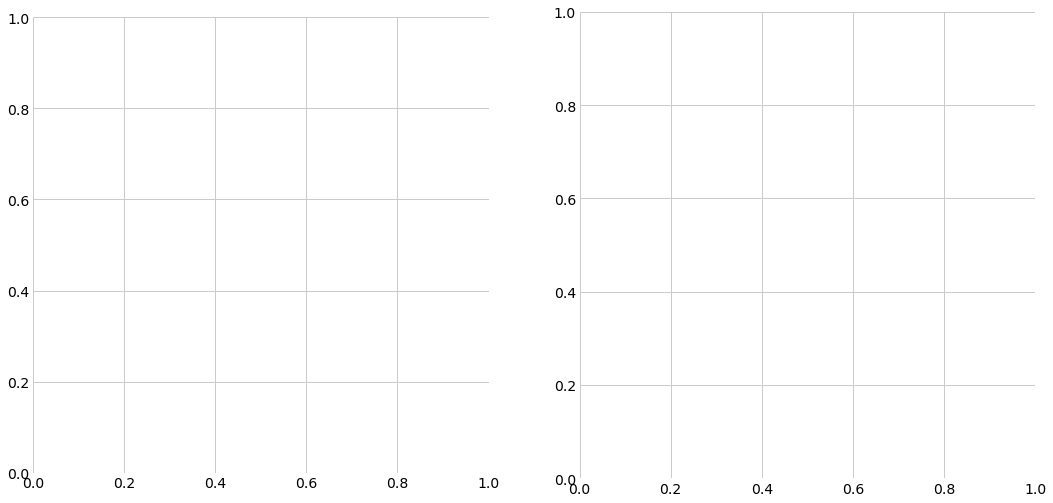

In [5]:
%%time 
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "edinburgh", fittype = "linear")
show_fits(fittedM0, fittedT1); 

In [6]:
%%time
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "edinburgh", fittype = "nonlinear")
show_fits(fittedM0, fittedT1)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [7]:
%%time
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "sydney", fittype = "linear")
show_fits(fittedM0, fittedT1)

CPU times: user 53.4 s, sys: 41.1 ms, total: 53.4 s
Wall time: 53.4 s


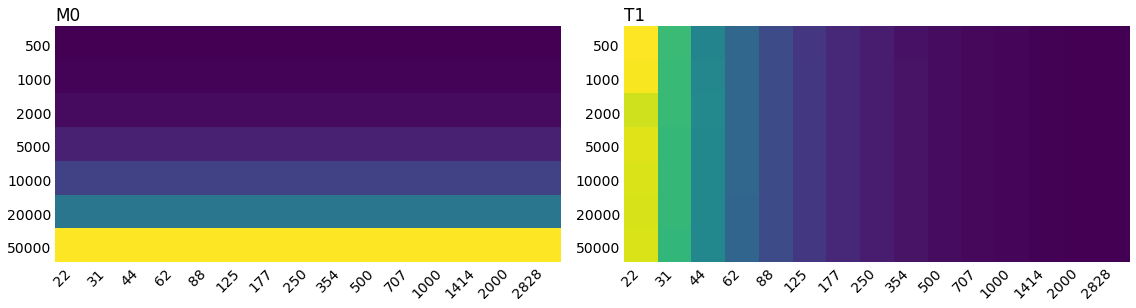

In [22]:
%%time 
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "sydney", fittype = "nonlinear")
show_fits(fittedM0, fittedT1)

CPU times: user 126 ms, sys: 5.07 ms, total: 131 ms
Wall time: 130 ms


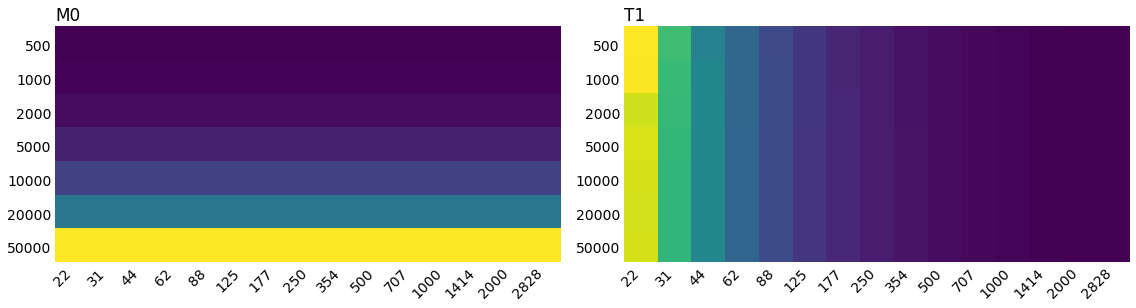

In [23]:
%%time
fittedM0, fittedT1 = vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "mcgill", fittype = "nonlinear")
show_fits(fittedM0, fittedT1)

CPU times: user 94.9 ms, sys: 6.1 ms, total: 101 ms
Wall time: 99.6 ms


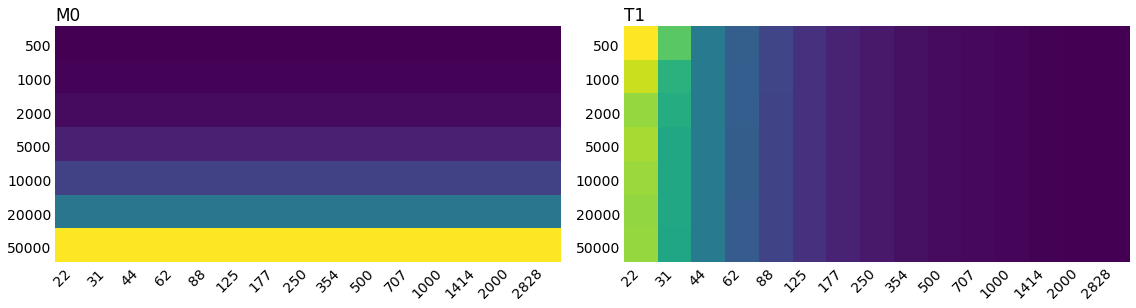

In [24]:
%%time
fittedM0, fittedT1 = vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "mcgill", fittype = "linear")
show_fits(fittedM0, fittedT1)

In [16]:
%%time
fittedM0, fittedT1 = vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "mcgill", fittype = "nonlinear")

CPU times: user 2.35 s, sys: 235 ms, total: 2.59 s
Wall time: 198 ms


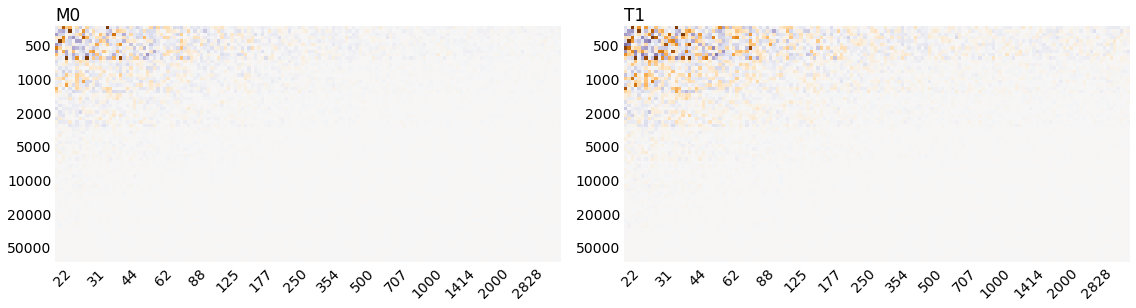

In [17]:
show_err(fittedM0[:,:,0], fittedT1[:,:,0])

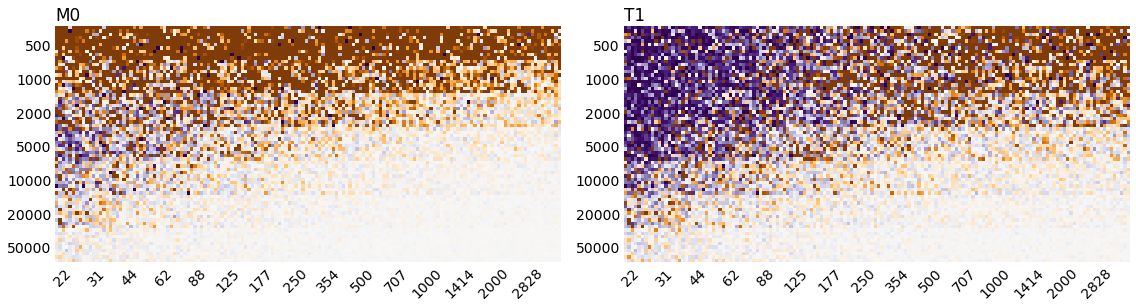

In [18]:
show_err(fittedM0[:,:,-1], fittedT1[:,:,-1])